In [37]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.pipeline import Pipeline
import joblib

In [38]:
permit_types_to_keep = [
    'unincorporated building residential',
    'road',
    'unincorporated electrical',
    'unincorporated mechanical',
    'fire',
    'unincorporated sewer'
]
df_clean = pd.read_csv("permit_data_cleaned.csv")
df_filtered = df_clean[df_clean['PERMITTYPE'].isin(permit_types_to_keep)].copy()
df_filtered.to_csv("permit_data_filtered.csv", index=False)

In [39]:
DATA_FILE = "permit_data_filtered.csv"
MODEL_SAVE_PATH = "permit_classifier_pipeline.joblib"
TEXT_COLUMN = "DESCRIPTION"
TARGET_COLUMN = "PERMITTYPE"
TEST_SIZE = 0.2 
RANDOM_STATE = 42

In [40]:
print(f"Loading data from {DATA_FILE}...")
try:
    df = pd.read_csv(DATA_FILE)
    df[TEXT_COLUMN] = df[TEXT_COLUMN].fillna('')
    print(f"Loaded {len(df)} rows.")
    print("Target variable distribution:")
    print(df[TARGET_COLUMN].value_counts())
except FileNotFoundError:
    print(f"Error: Data file '{DATA_FILE}' not found. Please run cleaning script first.")
    exit()
except Exception as e:
    print(f"Error loading data: {e}")
    exit()

if df.empty:
    print("Error: DataFrame is empty after loading. Cannot train model.")
    exit()

Loading data from permit_data_filtered.csv...
Loaded 219531 rows.
Target variable distribution:
PERMITTYPE
unincorporated building residential    65664
road                                   61945
unincorporated electrical              52176
unincorporated mechanical              29287
unincorporated sewer                   10178
fire                                     281
Name: count, dtype: int64


In [41]:
X = df[TEXT_COLUMN]
y = df[TARGET_COLUMN]

In [42]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y 
)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

print("Building model pipeline (TF-IDF Vectorizer -> Logistic Regression)...")
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, 
                             ngram_range=(1, 2), #
                             stop_words='english')), 
    ('clf', LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)) 
])

Training set size: 175624
Test set size: 43907
Building model pipeline (TF-IDF Vectorizer -> Logistic Regression)...


In [43]:
print("Training model...")
try:
    pipeline.fit(X_train, y_train)
    print("Training complete.")
except Exception as e:
    print(f"Error during model training: {e}")
    print("\nTraining target variable distribution:")
    print(y_train.value_counts())
    exit()

Training model...
Training complete.


In [44]:
print("\nEvaluating model on the test set...")
y_pred = pipeline.predict(X_test)


Evaluating model on the test set...


In [45]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
try:
    labels = sorted(list(set(y_test) | set(y_pred)))
    print(classification_report(y_test, y_pred, labels=labels, zero_division=0))
except Exception as e:
     print(f"Could not generate classification report: {e}")

Accuracy: 0.9253

Classification Report:
                                     precision    recall  f1-score   support

                               fire       0.93      0.75      0.83        56
                               road       0.99      0.99      0.99     12389
unincorporated building residential       0.86      0.97      0.91     13133
          unincorporated electrical       0.95      0.87      0.91     10435
          unincorporated mechanical       0.90      0.82      0.86      5858
               unincorporated sewer       0.97      0.80      0.88      2036

                           accuracy                           0.93     43907
                          macro avg       0.93      0.87      0.90     43907
                       weighted avg       0.93      0.93      0.92     43907



In [46]:
new_descriptions = ["voluntary seismic retrofit work is to be performed in accordance with la city standard plan"]
predictions = pipeline.predict(new_descriptions)
print(f"\nExample predictions for: {new_descriptions}")
print()
print(predictions)


Example predictions for: ['voluntary seismic retrofit work is to be performed in accordance with la city standard plan']

['unincorporated building residential']


In [47]:
joblib.dump(pipeline, MODEL_SAVE_PATH)

['permit_classifier_pipeline.joblib']


Generating Confusion Matrix...
Confusion Matrix saved to confusion_matrix.png


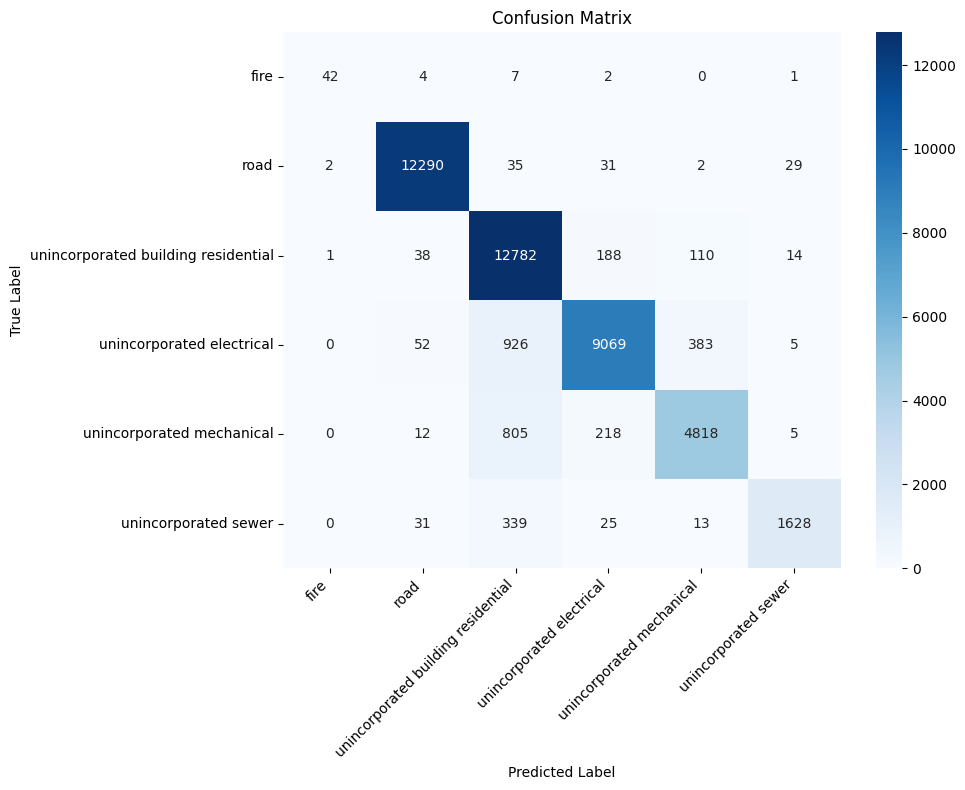

In [48]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("\nGenerating Confusion Matrix...")
try:
    cm = confusion_matrix(y_test, y_pred, labels=pipeline.classes_) # Use labels found during fit
    plt.figure(figsize=(10, 8)) # Adjust figure size as needed
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=pipeline.classes_, yticklabels=pipeline.classes_)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.xticks(rotation=45, ha='right') # Rotate labels if they overlap
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig('confusion_matrix.png') # Save the plot
    print("Confusion Matrix saved to confusion_matrix.png")
    # plt.show() # Uncomment if running interactively and want to display plot
except Exception as e:
    print(f"Could not generate or save confusion matrix: {e}")